# Claira Project: Mortgage Contracts

## Import Packages

In [294]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import numpy as np
import gzip
import seaborn as sns
np.random.seed(99)
RANDOM_STATE = 99
import datetime
pd.set_option('display.max_rows', 151)


# Import vectorizing and modeling tools in preparation for modeling steps
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text, stop_words
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.utils import resample

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import spacy
import en_core_web_lg
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Import Data

In [230]:
# Import the CSV file
# raw_df = pd.read_csv('../data/sasb_cash_trap_triggers.csv')

In [231]:
# Import the CSV file
raw_df = pd.read_csv('../data/sasb_cash_trap_triggers_06_09_20.csv')

In [232]:
# Review the first few rows of the data set
raw_df.head()

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"On each Business Day, the financial institution maintaining the blocked account (which was U.S. Bank National Association as of the Origination Date) is required to remit all funds on deposit in the blocked account (a) if no Trigger Period or event of default under the Mortgage Loan is continuing, to the Borrower and (b) during a Trigger Period or while an event of default under the Mortgage Loan is continuing, to the Cash Management Account.",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"The Borrower has established and is required to maintain a cash management account (the “Cash Management Account”) at the Cash Management Bank into which income from the Property (other than certain de minimis non-core and sponsorship income) is required to be deposited during any period that the aggregate debt service coverage ratio (based on net operating income, as calculated under the Loan Documents) for the trailing 12-month period as of the most recent fiscal quarter and annualized debt service (including any scheduled amortization), falls below 1.30x as of the end of any fiscal quarter until such debt service coverage ratio exceeds 1.30x as of the end of the trailing 12-month period for two consecutive fiscal quarters (such period a “Trigger Period”), or while an event of default under the Mortgage Loan is continuing.",Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"The Borrower has established and is required to maintain a cash management account (the “Cash Management Account”) at the Cash Management Bank into which income from the Property (other than certain de minimis non-core and sponsorship income) is required to be deposited during any period that the aggregate debt service coverage ratio (based on net operating income, as calculated under the Loan Documents) for the trailing 12-month period as of the most recent fiscal quarter and annualized debt service (including any scheduled amortization), falls below 1.30x as of the end of any fiscal quarter until such debt service coverage ratio exceeds 1.30x as of the end of the trailing 12-month period for two consecutive fiscal quarters (such period a “Trigger Period”), or while an event of default under the Mortgage Loan is continuing.",Loan Default,1
3,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"During a Trigger Period or while an event of default under the Mortgage Loan is continuing, all amounts available in the Cash Management Account will be applied on each Loan Payment Date in the following order of priority: (i) to the Tax and Insurance Reserve Account, (a) 1/12th of projected annual taxes and (b) 1/12th of projected annual insurance premiums (unless certain blanket policies are in effect), (ii) to the lender, the amount of all scheduled or delinquent interest and principal on the Mortgage Loan and all other amounts then due and payable under the Loan Documents (with amounts in respect of principal paid last), (iii) provided there has been no enforcement action, after the occurrence and during the continuance of an event of default under the Mortgage Loan, to operating accounts, an amount equal to the budgeted operating expenses for the month in which such Loan Payment Date occurs (as described in “Description of the Mortgage Loan—Cash Management”); (iv) to the Capital Expenditure Reserve Account,􀀃an amount equal to the lesser of (a) $9,018 (which is $0.15 per owned rentable square foot per annum) or (b) the amount that would cause the total amount contained in the Capital Expenditure Reserve Account to equal $108,216 (which is 12 times the monthly required amount set forth in clause (a)), (v) to the TI/LC Reserve Account an amount equal to the lesser of (a) $60,120 (which is $1.00 per owned rentable square foot per annum) or (b) the amount that would cause the total amount contained in the Capital Expenditure Reserve Account

In [233]:
# Check size of the data set
raw_df.shape

(2247, 4)

In [234]:
raw_df = raw_df[['Document', 'Sentence', 'Trigger', 'Multiclass']]

In [235]:
# Check for null values
raw_df.isnull().sum()

Document      0
Sentence      0
Trigger       0
Multiclass    0
dtype: int64

In [236]:
raw_df.dropna()
raw_df.shape

(2247, 4)

In [237]:
raw_df.head(11)

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"On each Business Day, the financial institution maintaining the blocked account (which was U.S. Bank National Association as of the Origination Date) is required to remit all funds on deposit in the blocked account (a) if no Trigger Period or event of default under the Mortgage Loan is continuing, to the Borrower and (b) during a Trigger Period or while an event of default under the Mortgage Loan is continuing, to the Cash Management Account.",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"The Borrower has established and is required to maintain a cash management account (the “Cash Management Account”) at the Cash Management Bank into which income from the Property (other than certain de minimis non-core and sponsorship income) is required to be deposited during any period that the aggregate debt service coverage ratio (based on net operating income, as calculated under the Loan Documents) for the trailing 12-month period as of the most recent fiscal quarter and annualized debt service (including any scheduled amortization), falls below 1.30x as of the end of any fiscal quarter until such debt service coverage ratio exceeds 1.30x as of the end of the trailing 12-month period for two consecutive fiscal quarters (such period a “Trigger Period”), or while an event of default under the Mortgage Loan is continuing.",Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"The Borrower has established and is required to maintain a cash management account (the “Cash Management Account”) at the Cash Management Bank into which income from the Property (other than certain de minimis non-core and sponsorship income) is required to be deposited during any period that the aggregate debt service coverage ratio (based on net operating income, as calculated under the Loan Documents) for the trailing 12-month period as of the most recent fiscal quarter and annualized debt service (including any scheduled amortization), falls below 1.30x as of the end of any fiscal quarter until such debt service coverage ratio exceeds 1.30x as of the end of the trailing 12-month period for two consecutive fiscal quarters (such period a “Trigger Period”), or while an event of default under the Mortgage Loan is continuing.",Loan Default,1
3,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"During a Trigger Period or while an event of default under the Mortgage Loan is continuing, all amounts available in the Cash Management Account will be applied on each Loan Payment Date in the following order of priority: (i) to the Tax and Insurance Reserve Account, (a) 1/12th of projected annual taxes and (b) 1/12th of projected annual insurance premiums (unless certain blanket policies are in effect), (ii) to the lender, the amount of all scheduled or delinquent interest and principal on the Mortgage Loan and all other amounts then due and payable under the Loan Documents (with amounts in respect of principal paid last), (iii) provided there has been no enforcement action, after the occurrence and during the continuance of an event of default under the Mortgage Loan, to operating accounts, an amount equal to the budgeted operating expenses for the month in which such Loan Payment Date occurs (as described in “Description of the Mortgage Loan—Cash Management”); (iv) to the Capital Expenditure Reserve Account,􀀃an amount equal to the lesser of (a) $9,018 (which is $0.15 per owned rentable square foot per annum) or (b) the amount that would cause the total amount contained in the Capital Expenditure Reserve Account to equal $108,216 (which is 12 times the monthly required amount set forth in clause (a)), (v) to the TI/LC Reserve Account an amount equal to the lesser of (a) $60,120 (which is $1.00 per owned rentable square foot per annum) or (b) the amount that would cause the total amount contained in the Capital Expenditure Reserve Account

## Data Cleaning

In [238]:
# Review number of Trigger types
raw_df['Trigger'].value_counts()

nontrigger                   1056
Unspecified                   356
Loan Default                  335
Debt Yield Fall               124
Loan default                   75
Mezzanine Default              57
Bankruptcy                     43
Tenant Failure                 37
Debt yield fall                34
Renovations                    24
DSCR Fall                      19
Operator Termination           19
Sponsor Termination            14
Aggregate Debt Yield Fall      11
Mezzanine Outstanding          10
SFF                             9
Mezzanine default               8
Aggregate debt yield fall       6
Aggregate DSCR Fall             5
Debt Yield Falll                4
Aggregate debt yield            1
Name: Trigger, dtype: int64

In [239]:
# Convert each category to Title format (to remove discrepancies based on capitalization)
raw_df['Trigger'] = raw_df['Trigger'].str.title()

In [240]:
raw_df['Trigger'] = raw_df['Trigger'].str.replace('Falll', 'Fall')

In [241]:
raw_df.loc[raw_df['Trigger'] == 'Aggregate Debt Yield', 'Trigger'] = 'Aggregate Debt Yield Fall'

In [242]:
raw_df['Sentence'] = raw_df['Sentence'].replace({'\$':''}, regex = True)

In [243]:
# Review clean Trigger Types
raw_df['Trigger'].value_counts()

Nontrigger                   1056
Loan Default                  410
Unspecified                   356
Debt Yield Fall               162
Mezzanine Default              65
Bankruptcy                     43
Tenant Failure                 37
Renovations                    24
Operator Termination           19
Dscr Fall                      19
Aggregate Debt Yield Fall      18
Sponsor Termination            14
Mezzanine Outstanding          10
Sff                             9
Aggregate Dscr Fall             5
Name: Trigger, dtype: int64

In [244]:
# Rename first column (document title)
# raw_df = raw_df.rename(columns = {'0': 'Document'})

In [245]:
# Drop Multiclass column for now 
raw_df = raw_df.drop('Multiclass', axis = 1)


In [246]:
raw_df.shape

(2247, 3)

In [247]:
# Count the number of distinct documents
num_docs = raw_df['Document'].nunique()
print(f'{num_docs} unique documents have been included in the data set')

27 unique documents have been included in the data set


In [248]:
# Review the distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf    176
20190220_02IPLU_Prospectus_SD000000002587491183.pdf    138
20190220_02IUQ7_Prospectus_SD000000002587520085.pdf    135
20160510_02B0XU_Prospectus_SD000000002312723382.pdf    125
20190108_02IFF1_Prospectus_SD000000002570458466.pdf    118
20190131_02IFCW_Prospectus_SD000000002578232050.pdf    114
20190131_02IFDN_Prospectus_SD000000002578234912.pdf    112
20190131_02IFE7_Prospectus_SD000000002578234792.pdf    111
20190208_02IM7M_Prospectus_SD000000002581684036.pdf    109
20190220_02IUQG_Prospectus_SD000000002587491537.pdf    100
20190205_02IJ77_Prospectus_SD000000002579874729.pdf     99
20170616_02DNAM_Prospectus_SD000000002355931744.pdf     84
20180125_02FE6L_Prospectus_SD000000002394837596.pdf     82
20170814_02E227_Prospectus_SD000000002367167139.pdf     82
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf     76
20170727_02DTVX_Prospectus_SD000000002362015714.pdf     75
20170525_02DFUI_Prospectus_SD000000002352389122.pdf     

In [249]:
# Summarize the trigger counts for the existing Document set
max_triggers = raw_df['Document'].value_counts().max()
min_triggers = raw_df['Document'].value_counts().min()
print(f'The {num_docs} Documents have tag counts that range from {min_triggers} to {max_triggers}.')

The 27 Documents have tag counts that range from 25 to 176.


In [250]:
# Check for duplicate rows
# raw_df['is_duplicate'] = raw_df.duplicated(subset = None)
# raw_df['is_duplicate'].value_counts()

In [251]:
# num_duplicated_rows = (raw_df['is_duplicate'] == True).sum()
# print(f'There are {num_duplicated_rows} row duplicates in the data set.')

In [252]:
# This removes duplicate rows, but those rows are in fact legitimate in the document
# raw_df = raw_df.drop('is_duplicate', axis = 1)
# raw_df = raw_df.drop_duplicates()

In [253]:
# raw_df.shape

In [254]:
# raw_df.head()

In [255]:
# Review new number of Trigger types
raw_df['Trigger'].value_counts()

Nontrigger                   1056
Loan Default                  410
Unspecified                   356
Debt Yield Fall               162
Mezzanine Default              65
Bankruptcy                     43
Tenant Failure                 37
Renovations                    24
Operator Termination           19
Dscr Fall                      19
Aggregate Debt Yield Fall      18
Sponsor Termination            14
Mezzanine Outstanding          10
Sff                             9
Aggregate Dscr Fall             5
Name: Trigger, dtype: int64

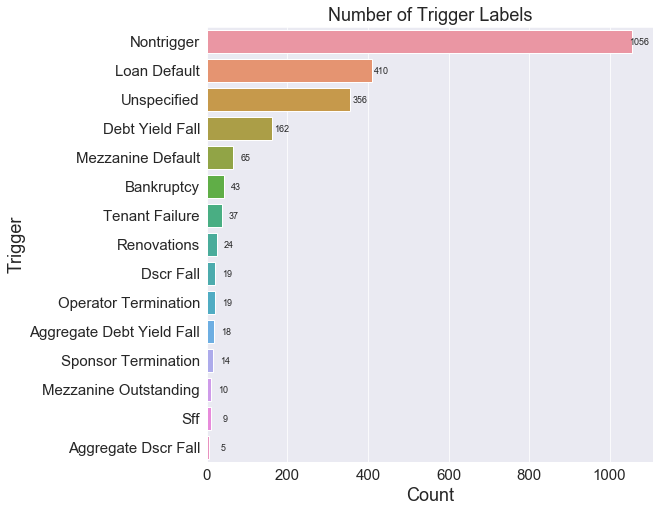

In [256]:
trigger_order = raw_df['Trigger'].value_counts().sort_values(ascending = False).index

fig = plt.gcf()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=raw_df['Trigger'], data=raw_df, orient = 'h', order = trigger_order)
ax.set_title('Number of Trigger Labels', fontsize = 18)

plt.xlabel('Count', fontsize = 18)
plt.ylabel('Trigger', fontsize = 18)
plt.tick_params(labelsize=15)

for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(17, -15),fontsize=9,textcoords='offset points', horizontalalignment='right')
    
#https://stackoverflow.com/questions/50190409/how-to-annotate-horizontal-seaborn-countplots

In [257]:
# Review new distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf    176
20190220_02IPLU_Prospectus_SD000000002587491183.pdf    138
20190220_02IUQ7_Prospectus_SD000000002587520085.pdf    135
20160510_02B0XU_Prospectus_SD000000002312723382.pdf    125
20190108_02IFF1_Prospectus_SD000000002570458466.pdf    118
20190131_02IFCW_Prospectus_SD000000002578232050.pdf    114
20190131_02IFDN_Prospectus_SD000000002578234912.pdf    112
20190131_02IFE7_Prospectus_SD000000002578234792.pdf    111
20190208_02IM7M_Prospectus_SD000000002581684036.pdf    109
20190220_02IUQG_Prospectus_SD000000002587491537.pdf    100
20190205_02IJ77_Prospectus_SD000000002579874729.pdf     99
20170616_02DNAM_Prospectus_SD000000002355931744.pdf     84
20180125_02FE6L_Prospectus_SD000000002394837596.pdf     82
20170814_02E227_Prospectus_SD000000002367167139.pdf     82
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf     76
20170727_02DTVX_Prospectus_SD000000002362015714.pdf     75
20170525_02DFUI_Prospectus_SD000000002352389122.pdf     

In [258]:
raw_df.dtypes

Document    object
Sentence    object
Trigger     object
dtype: object

## Reshape the Data

In this section, we'll reshape the data, such that each sentence is represented once, with separate categorization columns for each Trigger type

In [259]:
# function to reshape the dataframe such that the triggers are 0/1 columns. Remove duplicates
def reshape_trigger_representation(dataframe):
    # select trigger types
    trigger_types = list(dataframe['Trigger'].unique())
    trigger_types = [x for x in trigger_types if str(x) != 'nan']
    
    # create new dataframe with unique document-sentence pairs (no duplicates)
    reshaped = dataframe.drop('Trigger', axis = 1).drop_duplicates().reset_index().drop('index', axis = 1)
    
    # select rows by trigger, reassign as 1 or 0 (for True or False)
    for tt in trigger_types:
        # select part that is trigger_type
        temp = dataframe.loc[dataframe['Trigger'] == tt].copy()

        # create a new column of true with trigger name
        temp[tt.lower().replace(' ', '_')] = np.int64(1)
        temp.drop('Trigger', axis=1, inplace=True)
        temp[tt.lower().replace(' ', '_')] = temp[tt.lower().replace(' ', '_')].astype('Int64')
        
        # left join this adjusted column to the unique data
        reshaped = reshaped.merge(temp, how='left', left_on=['Document', 'Sentence'], right_on=['Document', 'Sentence'])
        reshaped = reshaped.drop_duplicates().reset_index().drop('index', axis = 1)
    
    # replace nulls with False
    reshaped = reshaped.fillna(0)    
    
    return reshaped

In [260]:
# Reshape our original dataframe
df = reshape_trigger_representation(raw_df)

In [261]:
df.head(5)

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
0,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"On each Business Day, the financial institution maintaining the blocked account (which was U.S. Bank National Association as of the Origination Date) is required to remit all funds on deposit in the blocked account (a) if no Trigger Period or event of default under the Mortgage Loan is continuing, to the Borrower and (b) during a Trigger Period or while an event of default under the Mortgage Loan is continuing, to the Cash Management Account.",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"The Borrower has established and is required to maintain a cash management account (the “Cash Management Account”) at the Cash Management Bank into which income from the Property (other than certain de minimis non-core and sponsorship income) is required to be deposited during any period that the aggregate debt service coverage ratio (based on net operating income, as calculated under the Loan Documents) for the trailing 12-month period as of the most recent fiscal quarter and annualized debt service (including any scheduled amortization), falls below 1.30x as of the end of any fiscal quarter until such debt service coverage ratio exceeds 1.30x as of the end of the trailing 12-month period for two consecutive fiscal quarters (such period a “Trigger Period”), or while an event of default under the Mortgage Loan is continuing.",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"During a Trigger Period or while an event of default under the Mortgage Loan is continuing, all amounts available in the Cash Management Account will be applied on each Loan Payment Date in the following order of priority: (i) to the Tax and Insurance Reserve Account, (a) 1/12th of projected annual taxes and (b) 1/12th of projected annual insurance premiums (unless certain blanket policies are in effect), (ii) to the lender, the amount of all scheduled or delinquent interest and principal on the Mortgage Loan and all other amounts then due and payable under the Loan Documents (with amounts in respect of principal paid last), (iii) provided there has been no enforcement action, after the occurrence and during the continuance of an event of default under the Mortgage Loan, to operating accounts, an amount equal to the budgeted operating expenses for the month in which such Loan Payment Date occurs (as described in “Description of the Mortgage Loan—Cash Management”); (iv) to the Capital Expenditure Reserve Account,􀀃an amount equal to the lesser of (a) 9,018 (which is 0.15 per owned rentable square foot per annum) or (b) the amount that would cause the total amount contained in the Capital Expenditure Reserve Account to equal 108,216 (which is 12 times the monthly required amount set forth in clause (a)), (v) to the TI/LC Reserve Account an amount equal to the lesser of (a) 60,120 (which is 1.00 per owned rentable square foot per annum) or (b) the amount that would cause the total amount contained in the Capital Expenditure Reserve Account to equal 721,438 (which is 12 times the monthly required amount set forth in clause (a)), and (vi) unless an event of default under the Loan Documents is continuing, all remaining amounts to the Borrower.",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,On any Business Day all amounts on deposit in the Cash Management Account in excess of the amount of required reserves and all other amounts due and payable on the next Loan Payment Date will be released to the Borrower unless an event of default under the Mortgage Loan has occurred and is continuing.,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,

## Resampling 

In [374]:
#Total sum per row: 
downsampling_set = df
downsampling_set.loc[:,'Total'] = downsampling_set.sum(axis=1)

# select only those with a single type of trigger
downsampling_set = downsampling_set[downsampling_set['Total'].isin([1,2])]
downsampling_set.head()



,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,Total
0,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"On each Business Day, the financial institution maintaining the blocked account (which was U.S. Bank National Association as of the Origination Date) is required to remit all funds on deposit in the blocked account (a) if no Trigger Period or event of default under the Mortgage Loan is continuing, to the Borrower and (b) during a Trigger Period or while an event of default under the Mortgage Loan is continuing, to the Cash Management Account.",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0
2,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"During a Trigger Period or while an event of default under the Mortgage Loan is continuing, all amounts available in the Cash Management Account will be applied on each Loan Payment Date in the following order of priority: (i) to the Tax and Insurance Reserve Account, (a) 1/12th of projected annual taxes and (b) 1/12th of projected annual insurance premiums (unless certain blanket policies are in effect), (ii) to the lender, the amount of all scheduled or delinquent interest and principal on the Mortgage Loan and all other amounts then due and payable under the Loan Documents (with amounts in respect of principal paid last), (iii) provided there has been no enforcement action, after the occurrence and during the continuance of an event of default under the Mortgage Loan, to operating accounts, an amount equal to the budgeted operating expenses for the month in which such Loan Payment Date occurs (as described in “Description of the Mortgage Loan—Cash Management”); (iv) to the Capital Expenditure Reserve Account,􀀃an amount equal to the lesser of (a) 9,018 (which is 0.15 per owned rentable square foot per annum) or (b) the amount that would cause the total amount contained in the Capital Expenditure Reserve Account to equal 108,216 (which is 12 times the monthly required amount set forth in clause (a)), (v) to the TI/LC Reserve Account an amount equal to the lesser of (a) 60,120 (which is 1.00 per owned rentable square foot per annum) or (b) the amount that would cause the total amount contained in the Capital Expenditure Reserve Account to equal 721,438 (which is 12 times the monthly required amount set forth in clause (a)), and (vi) unless an event of default under the Loan Documents is continuing, all remaining amounts to the Borrower.",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0
3,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,On any Business Day all amounts on deposit in the Cash Management Account in excess of the amount of required reserves and all other amounts due and payable on the next Loan Payment Date will be released to the Borrower unless an event of default under the Mortgage Loan has occurred and is continuing.,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0
4,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"Available funds in each Cash Management Account are required to be swept into either the Operating Accounts, or upon the commencement of a Trigger Period or Event of Default, the Cash Management Account at the end of each Business Day.",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0
5,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"So long as no Trigger Period or Event of Default is continuing, at the end of each Business Day, all amounts contained in the Lockbox Account will be required to be disbursed to the Borrower’s designated operating account or as Borrower otherwise directs.",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0


In [375]:
# get trigger columns
n = 10
trigger_cols = downsampling_set.drop(['Document', 'Sentence'], axis=1).sum(axis=0)
trigger_cols = trigger_cols.where(lambda x: x > n).dropna()
trigger_cols = [t for t in list(trigger_cols.index) if t not in ['Total', 'unspecified', 'nontrigger']]


In [376]:
# randomly sample n rows from the selected trigger columns without replacement - samples is the training set
init = True

for col in trigger_cols:
    temp_col = downsampling_set[downsampling_set[col] == 1]
    sampled_col = resample(temp_col, replace = False, n_samples = n, random_state = RANDOM_STATE)
    if init:
        samples = sampled_col
        init = False
    else:
        samples = pd.concat([samples,sampled_col])

# remove these rows from the main data set - select index and remove by index
rmv_index = list(samples.index)
filtered = df.drop(rmv_index, axis='index')


In [385]:

# make is trigger column
samples['istrigger'] = np.where(samples['nontrigger']>0, 0, 1)
filtered['istrigger'] = np.where(filtered['nontrigger']>0, 0, 1)

In [387]:
f = filtered.loc[filtered['istrigger']==1]
f

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,Total,istrigger
0,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"On each Business Day, the financial institution maintaining the blocked account (which was U.S. Bank National Association as of the Origination Date) is required to remit all funds on deposit in the blocked account (a) if no Trigger Period or event of default under the Mortgage Loan is continuing, to the Borrower and (b) during a Trigger Period or while an event of default under the Mortgage Loan is continuing, to the Cash Management Account.",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1
1,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"The Borrower has established and is required to maintain a cash management account (the “Cash Management Account”) at the Cash Management Bank into which income from the Property (other than certain de minimis non-core and sponsorship income) is required to be deposited during any period that the aggregate debt service coverage ratio (based on net operating income, as calculated under the Loan Documents) for the trailing 12-month period as of the most recent fiscal quarter and annualized debt service (including any scheduled amortization), falls below 1.30x as of the end of any fiscal quarter until such debt service coverage ratio exceeds 1.30x as of the end of the trailing 12-month period for two consecutive fiscal quarters (such period a “Trigger Period”), or while an event of default under the Mortgage Loan is continuing.",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,1
2,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"During a Trigger Period or while an event of default under the Mortgage Loan is continuing, all amounts available in the Cash Management Account will be applied on each Loan Payment Date in the following order of priority: (i) to the Tax and Insurance Reserve Account, (a) 1/12th of projected annual taxes and (b) 1/12th of projected annual insurance premiums (unless certain blanket policies are in effect), (ii) to the lender, the amount of all scheduled or delinquent interest and principal on the Mortgage Loan and all other amounts then due and payable under the Loan Documents (with amounts in respect of principal paid last), (iii) provided there has been no enforcement action, after the occurrence and during the continuance of an event of default under the Mortgage Loan, to operating accounts, an amount equal to the budgeted operating expenses for the month in which such Loan Payment Date occurs (as described in “Description of the Mortgage Loan—Cash Management”); (iv) to the Capital Expenditure Reserve Account,􀀃an amount equal to the lesser of (a) 9,018 (which is 0.15 per owned rentable square foot per annum) or (b) the amount that would cause the total amount contained in the Capital Expenditure Reserve Account to equal 108,216 (which is 12 times the monthly required amount set forth in clause (a)), (v) to the TI/LC Reserve Account an amount equal to the lesser of (a) 60,120 (which is 1.00 per owned rentable square foot per annum) or (b) the amount that would cause the total amount contained in the Capital Expenditure Reserve Account to equal 721,438 (which is 12 times the monthly required amount set forth in clause (a)), and (vi) unless an event of default under the Loan Documents is continuing, all remaining amounts to the Borrower.",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1
3,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,On any Business Day all amounts on deposit in the Cash Management Account in excess of the amount of required reserves and all other amounts due and payable on the next Loan Payment Date will be released to the Borrower unless an event of default under the Mortgage Loan has occurred and is continuing.,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1
4,20120828_01Y

In [285]:
loop_times = label_columns[label_columns['Total'].isin([1,2])].sum(axis = 0).median()
loop_times

14.0

In [296]:
loop_cols = list(label_columns.columns)
loop_cols = [ele for ele in loop_cols if ele not in ['Total']]
loop_cols

['loan_default',
 'aggregate_dscr_fall',
 'dscr_fall',
 'debt_yield_fall',
 'aggregate_debt_yield_fall',
 'mezzanine_default',
 'tenant_failure',
 'mezzanine_outstanding',
 'operator_termination',
 'bankruptcy',
 'sponsor_termination',
 'renovations',
 'sff']

In [305]:
samples = pd.DataFrame()

'''
for col in downsampling_set[loop_cols]:
    try:
        temp = df.loc[df[col] == 1]
        samples.append(resample(temp, replace = False, n_samples = loop_times, random_state = RANDOM_STATE))
    except (TypeError, ValueError):
        pass

samples    
#    downsampled_set = resample(downsampling_set, replace = False, n_samples = loop_times, random_state = RANDOM_STATE)
''' 

'\nfor col in downsampling_set[loop_cols]:\n    try:\n        temp = df.loc[df[col] == 1]\n        samples.append(resample(temp, replace = False, n_samples = loop_times, random_state = RANDOM_STATE))\n    except (TypeError, ValueError):\n        pass\n\nsamples    \n#    downsampled_set = resample(downsampling_set, replace = False, n_samples = loop_times, random_state = RANDOM_STATE)\n'

In [307]:
samples = samples.append(resample(downsampling_set, replace = False, n_samples = loop_times, random_state = RANDOM_STATE))

TypeError: slice indices must be integers or None or have an __index__ method

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,Total
289,20180125_02FE6L_Prospectus_SD000000002394837596.pdf,"“Cash Sweep Cure Date” means the first date following the occurrence of a Cash Sweep Event on which (i) with respect to a Cash Sweep Event caused by a Debt Yield Trigger Event, a Debt Yield Trigger Event Cure has taken place, (ii) with respect to a Cash Sweep Event caused by a Mortgage Loan Event of Default, no such Mortgage Loan Event of Default is continuing, (iii) with respect to a Cash Sweep Event caused by a Mezzanine Loan Event of Default, no such Mezzanine Loan Event of Default is continuing or (iv) with respect to a Cash Sweep Event as a result of a bankruptcy or insolvency event with respect to the Borrower, if the bankruptcy or insolvency event was an involuntary action not consented to by the Borrower or any SPE Constituent Entity, such action being discharged, stayed or dismissed within 90 days of its filing.",1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,4.0
290,20180125_02FE6L_Prospectus_SD000000002394837596.pdf,"“Cash Sweep Cure Date” means the first date following the occurrence of a Cash Sweep Event on which (i) with respect to a Cash Sweep Event caused by a Debt Yield Trigger Event, a Debt Yield Trigger Event Cure has taken place, (ii) with respect to a Cash Sweep Event caused by a Mortgage Loan Event of Default, no such Mortgage Loan Event of Default is continuing, (iii) with respect to a Cash Sweep Event caused by a Mezzanine Loan Event of Default, no such Mezzanine Loan Event of Default is continuing or (iv) with respect to a Cash Sweep Event as a result of a bankruptcy or insolvency event with respect to the Borrower, if the bankruptcy or insolvency event was an involuntary action not consented to by the Borrower or any SPE Constituent Entity, such action being discharged, stayed or dismissed within 90 days of its filing.",1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,4.0
291,20180125_02FE6L_Prospectus_SD000000002394837596.pdf,"“Cash Sweep Cure Date” means the first date following the occurrence of a Cash Sweep Event on which (i) with respect to a Cash Sweep Event caused by a Debt Yield Trigger Event, a Debt Yield Trigger Event Cure has taken place, (ii) with respect to a Cash Sweep Event caused by a Mortgage Loan Event of Default, no such Mortgage Loan Event of Default is continuing, (iii) with respect to a Cash Sweep Event caused by a Mezzanine Loan Event of Default, no such Mezzanine Loan Event of Default is continuing or (iv) with respect to a Cash Sweep Event as a result of a bankruptcy or insolvency event with respect to the Borrower, if the bankruptcy or insolvency event was an involuntary action not consented to by the Borrower or any SPE Constituent Entity, such action being discharged, stayed or dismissed within 90 days of its filing.",1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,4.0
292,20180125_02FE6L_Prospectus_SD000000002394837596.pdf,"“Cash Sweep Cure Date” means the first date following the occurrence of a Cash Sweep Event on which (i) with respect to a Cash Sweep Event caused by a Debt Yield Trigger Event, a Debt Yield Trigger Event Cure has taken place, (ii) with respect to a Cash Sweep Event caused by a Mortgage Loan Event of Default, no such Mortgage Loan Event of Default is continuing, (iii) with respect to a Cash Sweep Event caused by a Mezzanine Loan Event of Default, no such Mezzanine Loan Event of Default is continuing or (iv) with respect to a Cash Sweep Event as a result of a bankruptcy or insolvency event with respect to the Borrower, if the bankruptcy or insolvency event was an involuntary action not consented to by the Borrower or any SPE Constituent Entity, such action being discharged, stayed or dismissed within 90 days of its filing.",1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,4.0
293,20180125_02FE6L_Prospectus_SD00000000239

In [34]:
# Export reshaped to CSV file
#df.to_csv('../data/reshaped_06_04_20.csv')

In [35]:
# Create a dataframe showing the document tagging details (removing sentence details)
doc_view = df.groupby('Document').sum()


In [36]:
doc_view['sum'] = doc_view.sum(axis = 1)
doc_view

,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,sum
Document,,,,,,,,,,,,,,,,
20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,17,1,2,0,0,0,0,0,0,0,0,0,0,46,0,66.0
20150307_028S2X_Prospectus_SD000000002389024187.pdf,15,0,4,10,0,0,0,0,0,0,0,0,0,27,0,56.0
20160310_02AQCW_Prospectus_SD0000000-2003264558.pdf,7,0,0,6,5,3,2,2,0,0,0,0,0,0,0,25.0
20160510_02B0XU_Prospectus_SD000000002312723382.pdf,18,0,10,5,0,0,10,0,4,17,0,0,0,79,0,143.0
20170525_02DFUI_Prospectus_SD000000002352389122.pdf,12,0,7,8,0,0,4,0,6,0,0,0,0,31,0,68.0
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf,28,0,0,9,19,0,0,0,0,0,9,0,0,33,0,98.0
20170616_02DNAM_Prospectus_SD000000002355931744.pdf,12,1,1,7,0,0,7,0,0,0,0,0,0,56,0,84.0
20170727_02DTVX_Prospectus_SD000000002362015714.pdf,22,0,0,8,5,0,0,0,0,0,0,0,0,40,0,75.0
20170801_02DX5C_Prospectus_SD000000002363000910.pdf,6,0,0,16,7,0,0,0,0,0,0,0,0,37,0,66.0


In [37]:
# Export reshaped to CSV file
# doc_view.to_csv('../data/exported_data/doc_view_06_09_20.csv')

In [38]:
# Isolate documents that don't have any Trigger tags (only nontriggers)
no_trigger_tags = list(doc_view.loc[doc_view['sum'] == doc_view['nontrigger']].index)
no_trigger_tags # Save document names to a list

[]

In [39]:
# we will remove any documents that have 0 Cash Trap Trigger clauses within the data set

to_remove = df[df['Document'].isin(no_trigger_tags)]
df = df.drop(to_remove.index)

In [40]:
df.shape

(2041, 17)

## Feature Engineering

In [41]:
# Create a column with length of Sentence
df['sentence_char_count'] = df['Sentence'].str.len()

In [42]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,sentence_char_count
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,446
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,837
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1766
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,302
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,235


## Natural Language Processing of the sentence column

In [43]:
nlp = spacy.load('en_core_web_sm', disable = 'parser')

In [44]:
# Review a tokenized sample Sentence
[token.text for token in nlp(df['Sentence'][2])]

['During',
 'a',
 'Trigger',
 'Period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'Mortgage',
 'Loan',
 'is',
 'continuing',
 ',',
 'all',
 'amounts',
 'available',
 'in',
 'the',
 'Cash',
 'Management',
 'Account',
 'will',
 'be',
 'applied',
 'on',
 'each',
 'Loan',
 'Payment',
 'Date',
 'in',
 'the',
 'following',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'Tax',
 'and',
 'Insurance',
 'Reserve',
 'Account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'taxes',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'insurance',
 'premiums',
 '(',
 'unless',
 'certain',
 'blanket',
 'policies',
 'are',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'scheduled',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'Mortgage',
 'Loan',
 'and',
 'all',
 'other',
 'amounts',
 'then',
 'due',
 'and',
 'payab

In [45]:
# Review a lemmatized sample Sentence
[token.lemma_ for token in nlp(df['Sentence'][2])]

['during',
 'a',
 'trigger',
 'period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'mortgage',
 'loan',
 'be',
 'continue',
 ',',
 'all',
 'amount',
 'available',
 'in',
 'the',
 'cash',
 'management',
 'account',
 'will',
 'be',
 'apply',
 'on',
 'each',
 'loan',
 'payment',
 'date',
 'in',
 'the',
 'follow',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'tax',
 'and',
 'insurance',
 'reserve',
 'account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'tax',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'insurance',
 'premium',
 '(',
 'unless',
 'certain',
 'blanket',
 'policy',
 'be',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'schedule',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'mortgage',
 'loan',
 'and',
 'all',
 'other',
 'amount',
 'then',
 'due',
 'and',
 'payable',
 'under',
 'the

In [46]:
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

df['SentenceTokens'] = df['Sentence'].apply(tokenize)

In [47]:
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

df['SentenceLemmas'] = df['Sentence'].apply(lemmatize)

In [48]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,sentence_char_count,SentenceTokens,SentenceLemmas
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,446,"On each Business Day , the financial instituti...","on each business day , the financial instituti..."
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,837,The Borrower has established and is required t...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1766,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,302,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,235,Available funds in each Cash Management Accoun...,available fund in each cash management account...


In [49]:
# Put all sentences into a list of review tokens
all_sentence_tokens = ' '.join(df['SentenceTokens'])
all_sentence_tokens[:75]

'On each Business Day , the financial institution maintaining the blocked ac'

In [50]:
# Put all sentences into a list of review lemmas
all_sentence_lemmas = ' '.join(df['SentenceLemmas'])
all_sentence_lemmas[:75]

'on each business day , the financial institution maintain the block account'

In [51]:
sentence_token_list = [token for token in all_sentence_tokens.split(' ')]
sentence_lemma_list = [lemma for lemma in all_sentence_lemmas.split(' ')]

In [52]:
token_df = pd.Series(sentence_token_list)
lemma_df = pd.Series(sentence_lemma_list)

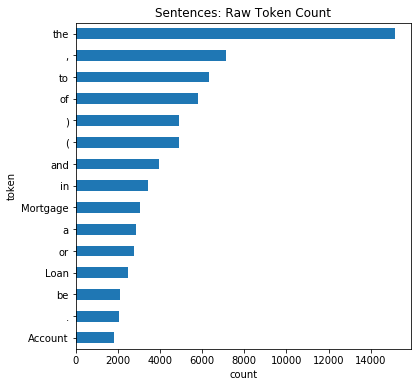

In [53]:
# Plotting the raw token count
token_series = token_df.value_counts().head(15).sort_values(ascending = True)
ax = token_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('token')
ax.set_title('Sentences: Raw Token Count');

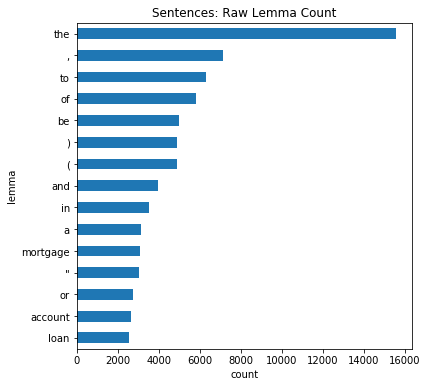

In [54]:
# Plotting the raw lemma count
lemma_series = lemma_df.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Raw Lemma Count');

In [55]:
# Remove punctuation, maintain letters and numbers
df['SentenceLemmas_nopunc'] = df['SentenceLemmas'].str.replace("[^a-zA-Z0-9#']", " ")

In [56]:
# Put all SentenceLemmas_nopunc into a list
all_lemmas_nopunc = ' '.join(df['SentenceLemmas_nopunc'])
lemma_list_nopunc = [lemma for lemma in all_lemmas_nopunc.split(' ')]
lemma_list_nopunc = [lemma for lemma in lemma_list_nopunc if lemma not in ['']]
lemma_list_nopunc[:10]

['on',
 'each',
 'business',
 'day',
 'the',
 'financial',
 'institution',
 'maintain',
 'the',
 'block']

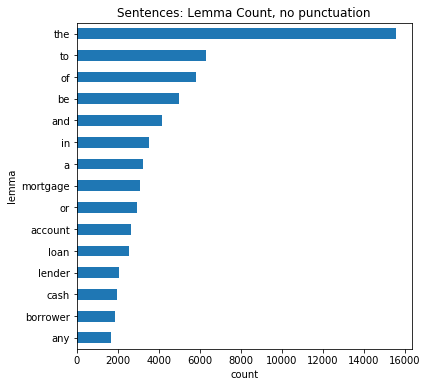

In [57]:
# Create a data series containing the list of words
lemma_df_nopunc = pd.Series(lemma_list_nopunc)
lemma_series_nopunc = lemma_df_nopunc.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series_nopunc.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Lemma Count, no punctuation');

In [58]:
df['SentenceLemmas_nopunc'].head()

0    on each business day   the financial instituti...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

In [59]:
df['SentenceLemmas_nopunc'] = df['SentenceLemmas_nopunc'].str.replace('\s{2,}', ' ')

In [60]:
df['SentenceLemmas_nopunc'].head()

0    on each business day the financial institution...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

## Preprocessing and Preparation for Modeling

In [61]:
short_stopwords = ['the', 'to', 'of', 'be', 'and', 'in', 'a']
short_stopwords2 = ['the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that']
short_stopwords2 = ['or', 'the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that', 'as']

In [62]:
# Look at original stopword list
stopwords = list(STOP_WORDS)
stopwords

['his',
 'done',
 'through',
 'whom',
 'five',
 'herself',
 'no',
 'except',
 'see',
 'neither',
 'those',
 'become',
 'whither',
 'who',
 'nobody',
 'here',
 'toward',
 'beside',
 'wherein',
 'what',
 'perhaps',
 'everything',
 'never',
 'beforehand',
 'quite',
 'sometime',
 'call',
 'two',
 'which',
 'something',
 'have',
 'go',
 'mine',
 'very',
 'nothing',
 'only',
 'any',
 'formerly',
 'you',
 'had',
 'has',
 'elsewhere',
 'would',
 'your',
 'anyhow',
 'full',
 'not',
 'often',
 'former',
 'forty',
 'throughout',
 'another',
 'anywhere',
 'while',
 'front',
 'meanwhile',
 'sometimes',
 'part',
 'where',
 'still',
 'across',
 'more',
 'out',
 'therefore',
 'hers',
 'themselves',
 'whose',
 'some',
 'hereby',
 'several',
 'twelve',
 'well',
 'on',
 'to',
 'yourself',
 'four',
 'made',
 'wherever',
 'up',
 'whatever',
 'again',
 'himself',
 'please',
 'thereupon',
 'why',
 'ourselves',
 'between',
 'became',
 'thru',
 'around',
 'behind',
 'already',
 'besides',
 'every',
 'give',
 '

## Train/Test Split

In [63]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,...,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,sentence_char_count,SentenceTokens,SentenceLemmas,SentenceLemmas_nopunc
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,446,"On each Business Day , the financial instituti...","on each business day , the financial instituti...",on each business day the financial institution...
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,837,The Borrower has established and is required t...,the borrower have establish and be require to ...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1766,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,302,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,235,Available funds in each Cash Management Accoun...,available fund in each cash management account...,available fund in each cash management account...


In [64]:
# Start by predicting Loan Default trigger

target = 'mezzanine_default'


X = df['SentenceLemmas']
y = df[target]
indices = df.index

y = y.astype('int')

In [65]:
y.dtypes

dtype('int64')

In [66]:
# Checking shape of X and y 
print(f'X shape is {X.shape}')
print(f'y shape is {y.shape}')

X shape is (2041,)
y shape is (2041,)


In [67]:
y.value_counts()

0    1936
1     105
Name: mezzanine_default, dtype: int64

In [68]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size = 0.3, stratify = y, random_state = RANDOM_STATE)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(indices_train.shape, indices_test.shape)

(1428,) (1428,)
(613,) (613,)
(1428,) (613,)


In [69]:
X.head()

0    on each business day , the financial instituti...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas, dtype: object

In [70]:
X_train.shape[0]

1428

In [71]:
y_train.shape[0]

1428

## Modeling

### CountVectorizer + Logistic Regression GridSearch and modeling

In [72]:
# Define CVEC + Logistic Regression Pipeline
pipe_cvec = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver = 'liblinear', random_state = RANDOM_STATE))])
cvec_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],
    'cvec__stop_words': [None, short_stopwords, short_stopwords2],  
    'cvec__max_features': [100, 200, 400, 600, 1000],
    'cvec__min_df': [2],
    'cvec__max_df': [.99],
    }

gs_cvec = GridSearchCV(pipe_cvec, param_grid = cvec_params, cv = 3, scoring = 'f1')

# Start the timer.
t0 = time.time()

results_cvec = gs_cvec.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



Seconds elapsed for fitting: 59.934


In [73]:
t0 = time.time()
print(f'Training score is {results_cvec.score(X_train, y_train):.3f}')
print(f'Test score is {results_cvec.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_cvec.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.993
Test score is 0.918
Cross Validation score is 0.968
Seconds elapsed for score calculation: 1.327


In [74]:
print(f'Best Score:{(results_cvec.best_score_):.3f}')
print(f'Best Parameters :{results_cvec.best_params_}')

Best Score:0.965
Best Parameters :{'cvec__max_df': 0.99, 'cvec__max_features': 100, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': ['the', 'to', 'of', 'be', 'and', 'in', 'a']}


### 5: CountVectorizor + Random Forest

In [75]:
'''
# Define CVEC + Logistic Regression Pipeline
pipe_rf = Pipeline([('cvec', CountVectorizer()), ('rf', RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = 2))])
rf_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],
    'cvec__stop_words': [None, short_stopwords, short_stopwords2],  
    'cvec__max_features': [100, 200, 400, 800],
    'cvec__min_df': [2],
    'cvec__max_df': [.99],
    'rf__max_depth': [4,5, 6],
    'rf__min_samples_split': [2,3],
    'rf__min_samples_leaf': [10, 12]
    }

gs_rf = GridSearchCV(pipe_rf, param_grid = rf_params, cv = 3, scoring = 'f1')

# Start the timer.
t0 = time.time()

results_rf = gs_rf.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.

'''

"\n# Define CVEC + Logistic Regression Pipeline\npipe_rf = Pipeline([('cvec', CountVectorizer()), ('rf', RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = 2))])\nrf_params = {\n    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],\n    'cvec__stop_words': [None, short_stopwords, short_stopwords2],  \n    'cvec__max_features': [100, 200, 400, 800],\n    'cvec__min_df': [2],\n    'cvec__max_df': [.99],\n    'rf__max_depth': [4,5, 6],\n    'rf__min_samples_split': [2,3],\n    'rf__min_samples_leaf': [10, 12]\n    }\n\ngs_rf = GridSearchCV(pipe_rf, param_grid = rf_params, cv = 3, scoring = 'f1')\n\n# Start the timer.\nt0 = time.time()\n\nresults_rf = gs_rf.fit(X_train, y_train)\n\nprint(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.\n\n"

In [76]:
'''
t0 = time.time()
print(f'Training score is {results_rf.score(X_train, y_train):.3f}')
print(f'Test score is {results_rf.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_rf.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.
'''

"\nt0 = time.time()\nprint(f'Training score is {results_rf.score(X_train, y_train):.3f}')\nprint(f'Test score is {results_rf.score(X_test, y_test):.3f}')\nprint(f'Cross Validation score is {cross_val_score(results_rf.best_estimator_, X, y, cv = 3).mean():.3f}')\nprint(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.\n"

In [77]:
'''
print(f'Best Score: {results_rf.best_score_}')
print(f'Best Parameters: {results_rf.best_params_}')
'''

"\nprint(f'Best Score: {results_rf.best_score_}')\nprint(f'Best Parameters: {results_rf.best_params_}')\n"

## Model Selection
- In this section we compare the Train and Test scores across the various models

In [78]:
# Check Training Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_train, y_train):.3f}')
# print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_train, y_train):.3f}')
# print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_train, y_train):.3f}')
# print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_train, y_train):.3f}')
# print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_train, y_train):.3f}')

Baseline Score:                                0.948
CountVectorizer + LogisticRegression Accuracy: 0.993


In [79]:
# Check Testing Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_test, y_test):.3f}')
# print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_test, y_test):.3f}')
# print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_test, y_test):.3f}')
# print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_test, y_test):.3f}')
# print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_test, y_test):.3f}')

Baseline Score:                                0.948
CountVectorizer + LogisticRegression Accuracy: 0.918


## Model Evaluation - Logistic Regression

In [80]:
# Isolate the individual words and their coefficients
# Feature names (i.e., words in the Sentences):
names = results_cvec.best_estimator_.steps[0][1].get_feature_names()

# classifier (betas):
classifier = results_cvec.best_estimator_.named_steps['lr']

# https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

In [81]:
# Extract coefficients from the classifier defined above
coef_cvec = np.array(classifier.coef_).tolist()[0]
coef_cvec[:10] #Look at 10 coefficients

[0.2945488194501559,
 0.2945545246743635,
 -0.7701563165179045,
 0.1365798118072345,
 -0.29968064014324414,
 -0.27118829363209995,
 -0.14097325975039285,
 -0.34822853701928813,
 -0.8039508636029988,
 -0.6631601934882647]

In [82]:
# Create zipped list of the word names with their corresponding beta coefficients
cvec_top_words = list(zip(names, coef_cvec))

In [83]:
# Create final dataframe of words with their corresponding coefficients
df_cvec_coefs = pd.DataFrame(cvec_top_words).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = True)

In [84]:
# Top differentiating words and phrases for this Trigger type
df_cvec_coefs.tail(20).sort_values('coef', ascending = False)

,word,coef
58,mezzanine loan,1.199810
23,default,1.026617
57,mezzanine,0.924760
30,event,0.662508
48,loan agreement,0.627884
70,or,0.535258
42,ii,0.510385
73,payment,0.457240
13,cash,0.394160
92,trigger period,0.370118


In [85]:
# Display top opposing words and phrases for this Trigger type
df_cvec_coefs.head(20)

,word,coef
81,reserve,-0.992621
20,date,-0.815607
19,cure,-0.812029
8,applicable,-0.803951
2,account,-0.770156
47,loan,-0.726882
9,as,-0.663160
76,property,-0.657553
71,other,-0.645051
84,such,-0.620169


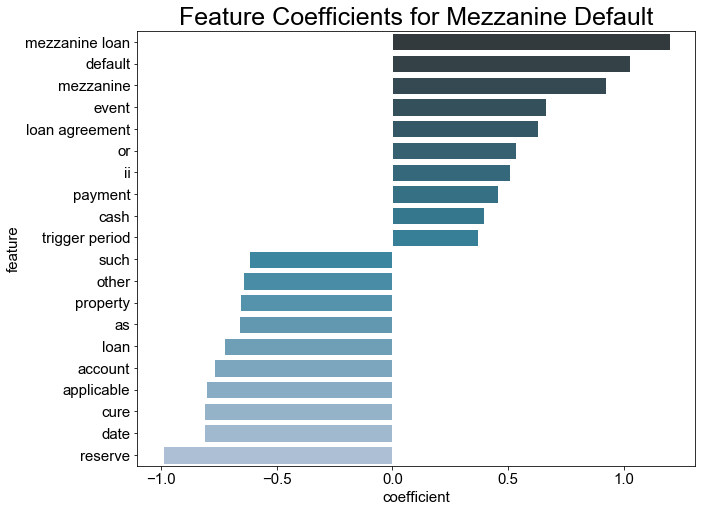

In [86]:
def coef_plot(category):
    '''
    Plots the top 10 and bottom 10 coefficients for the complexity category specified
    '''
    coefs_1 = df_cvec_coefs.sort_values(by=category, ascending=False).tail(10) # getting the top 10 coefficients
    coefs_2 = df_cvec_coefs.sort_values(by=category, ascending=False).head(10) # getting the bottom 10 coefficients
    coefs = pd.concat([coefs_2, coefs_1], axis = 0) # merging the two into one
    # plotting importance
    plt.figure(figsize=(10, 8)) # plotting the coefficients
    plt.title(f'Feature Coefficients for {target.replace("_", " ").title()}', fontsize=25)
    sns.set_style("darkgrid")
    sns.barplot(data=coefs,
                x=category,
                y='word',
                orient='h',
                palette = 'PuBuGn_d')
    plt.xlabel('coefficient', fontsize=15)
    plt.ylabel('feature', fontsize=15)
    plt.tick_params(labelsize=15)
coef_plot('coef')

## Calculating predictions and Confusion Matrix

In [87]:
# Here, we isolate our best model & make predictions based on our test data
best_model = results_cvec.best_estimator_
preds = best_model.predict(X_test)

In [88]:
# Checking our predictions
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [89]:
## Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, preds)
print('This is a confusion matrix for our test data vs predictions:')
print(cm_test)

This is a confusion matrix for our test data vs predictions:
[[580   1]
 [  4  28]]


In [90]:
# Converting our confusion matrix into a dataframe
cm_test = pd.DataFrame(cm_test, columns=['Predicted Negative','Predicted Positive'], 
                       index=['Actual Negative','Actual Positive'])

In [91]:
cm_test

,Predicted Negative,Predicted Positive
Actual Negative,580,1
Actual Positive,4,28


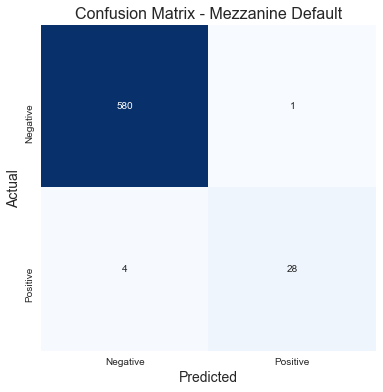

In [92]:
# Plot our confusion matrix
plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm_test, 
            annot=True, 
            ax = ax, 
            fmt='g', 
            cbar=False,
            cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_title(f'Confusion Matrix - {target.replace("_", " ").title()}', size=16)
ax.set_xlabel('Predicted', size=14)
ax.set_ylabel('Actual', size=14)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

In [93]:
# Setting up probabilities for the ROC curve
#pred_proba = results_cvec.predict_proba(X_test)
#preds = results_cvec.predict(X_test)



In [94]:
# Calculate probabilities
pred_proba = [i[1] for i in results_cvec.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df.shape

(613, 2)

In [95]:
# We establish the probabilities to be used to create the ROC curve
y_pred_proba = results_cvec.predict_proba(X_test)

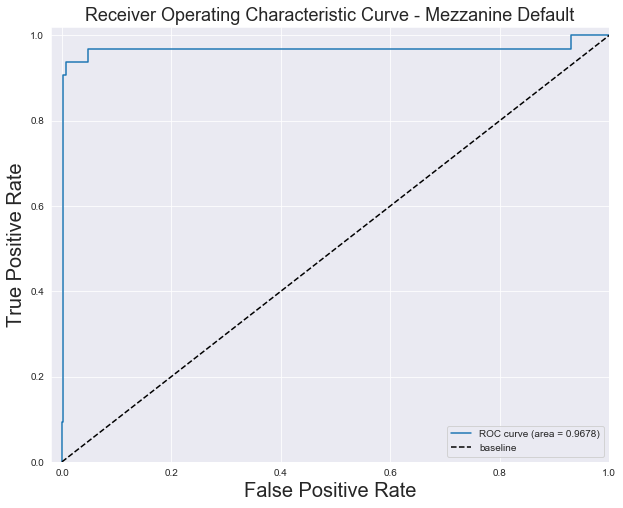

In [96]:
fpr, tpr, _= roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='baseline')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate', fontsize =20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title(f'Receiver Operating Characteristic Curve - {target.replace("_", " ").title()}', fontsize=18)
plt.legend(loc="lower right");

In [97]:
# To allow us to better read the Sentences
pd.set_option('display.max_colwidth', None)

In [98]:
result_cols = ['index', 'prediction', 'actual', 'model_input']
results = pd.DataFrame({'index': list(indices_test),'prediction': list(preds), 'actual': list(y_test), 'model_input': list(X_test)})

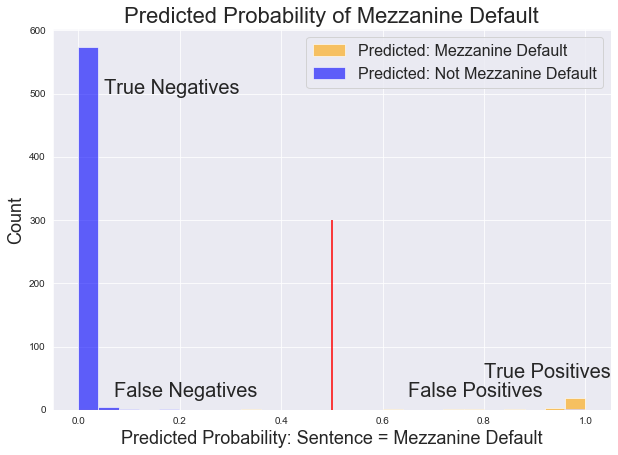

In [99]:
# Histogram overlay for two classes
plt.figure(figsize = (10,7))

# Create two histograms of observations.

plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = f'Predicted: {target.replace("_", " ").title()}')
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = f'Predicted: Not {target.replace("_", " ").title()}')


plt.vlines(x = .5,
           ymin = 0,
           ymax = 300,
           color = 'r',
           linestyle = '-')


# Label axes.
plt.title(f'Predicted Probability of {target.replace("_", " ").title()}', fontsize = 22)
plt.ylabel('Count', fontsize = 18)
plt.xlabel(f'Predicted Probability: Sentence = {target.replace("_", " ").title()}', fontsize = 18)

plt.annotate(xy = (0.05, 500), s = 'True Negatives', size = 20)
plt.annotate(xy = (0.07, 20), s = 'False Negatives', size = 20)
plt.annotate(xy = (0.65, 20), s = 'False Positives', size = 20)
plt.annotate(xy = (0.8, 50), s = 'True Positives', size = 20)

# Create legend.
plt.legend(fontsize = 16);

In [100]:
# set index as index column
results.set_index('index', inplace = True)
results.head()

,prediction,actual,model_input
index,,,
1332,0,0,"in no instance will the borrower request , nor will the lender be require to disburse , fund in the leasing reserve account with respect to any tenant improvement cost and/or lease commission to the extent that amount therefor have be reserve for in the unfunded obligations reserve account ."
1086,0,0,""" loss proceeds "" mean amount , award or payment payable to the borrowers or the lender in respect of all or any portion of any property in connection with a casualty or condemnation thereof ( after the deduction therefrom and payment to the borrowers and the lender , respectively , of any and all reasonable expense incur by the borrowers and the lender in the recovery thereof , include all attorneys’ fee and disbursement , the fee of insurance expert and adjuster and the cost incur in any litigation or arbitration with respect to such casualty or condemnation ) ."
1535,0,0,"mortgage lender will not be require to disburse capital expenditures reserve funds more frequently than once each calendar month nor in an amount less than the minimum disbursement amount ( or a less amount if the total amount of capital expenditures reserve funds be less than the minimum disbursement amount , in which case only one disbursement of the amount remain in the account will be make ) ."
1456,0,0,"the borrower agree to notify mortgage lender promptly of any change to the amount , schedule and instruction for payment of any ground rent of which -PRON- have or obtain knowledge and authorize mortgage lender or -PRON- agent to obtain any bill , invoice or statement for ground rent directly from the ground lessor ."
69,0,0,"the mortgage loan documents require the lender to maintain the cash management account , and the borrower to remit , or because to be remit fund into the operating account maintain by the hotel operator for disbursement into the cash management account and subsequent deposit into the follow reserve account , each of which be subaccount of the cash management account : an account for all amount payable in respect of tax and insurance premium ( the "" basic carrying costs escrow account "" ) which be , ( i ) on the origination date , in an amount equal to the sum of 1,083,335 in respect of tax , and ( ii ) on each mortgage loan payment date , an amount equal to the sum of ( a ) 1/12 of project annual tax , and ( b ) 1/12 of project annual insurance premium ; provide , that to the extent that the insurance require to be maintain by the borrower be effect under a blanket policy maintain by marriott international , inc. or -PRON- subsidiary and a marriott management period be continue and the lender receive evidence that such insurance satisfy the requirement of the mortgage loan agreement , the borrower be not require to reserve insurance premium in the basic carrying costs escrow account ; an account for the purpose of reserve amount in respect of replacement and capital repair at the property ( the "" ff&e reserve account "" ) in an amount equal to the great of ( i ) the amount require under the hotel operating agreement and ( ii ) 5 % of the monthly gross income from the property ( the "" ff&e monthly deposit "" ) ; provide , however , that during the continuance of a marriott management period or a period in which a qualified replacement hotel operator be manage the property , as applicable , the borrower will only be require to deposit ( or because to be deposit ) an amount , if any , equal to the difference between the amount reserve by the applicable hotel operator for ff&e under the hotel operating agreement and the ff&e monthly deposit as describe under "" description of the mortgage loan — reserve accounts — ff&e reserve account "" ; an account for the purpose of reserve amount anticipate to be require to correct any projected cash shortfall during slow business month ( the "" seasonality reserve account "" ) ; provide that to the extent the hotel operating agreement with the

In [101]:
misclassified = results[results['prediction'] != results['actual']]


In [102]:
misclassified = misclassified.merge(df, how = 'left', left_index = True, right_index = True)

In [103]:
misclassified = misclassified[['prediction', 'actual', 'model_input', 'Document', 'Sentence',
       'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger', 'sff']]

In [104]:
misclassified.head()

,prediction,actual,model_input,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,,,,
715,0,1,"cash management trigger ( i ) the occurrence of a mortgage loan or mezzanine loan event of default ; ( ii ) the debt yield , include both the mortgage and mezzanine loan , be less than ( a ) 6.25 % for two consecutive quarter with respect to the initial term and the first three extension term and ( b ) 7.00 % for two consecutive quarter with respect to the fourth and fifth extension",20190208_02IM7M_Prospectus_SD000000002581684036.pdf,"Cash Management Trigger (i) the occurrence of a mortgage loan or mezzanine loan event of default; (ii) the debt yield, including both the mortgage and mezzanine loans, being less than (a) 6.25% for two consecutive quarters with respect to the initial term and the first three extension terms and (b) 7.00% for two consecutive quarters with respect to the fourth and fifth extension",1,0,0,0,1,0,1,0,0,0,0,0,0,0,0
2017,0,1,"float rate component extensions two , 12-month extension option , subject to ( i ) no ongoing event of default , ( ii ) the purchase by borrower of an interest rate cap agreement , ( iii ) a 0.25 % extension fee for each extension , ( iv ) the debt yield base on lender ’s underwritten net operating income be not less 7.5 % for the first extension and 8.0 % for the second extension , ( v ) if mezzanine loan be outstanding , mezzanine borrower shall have exercise applicable extension option in accordance with mezzanine loan document , ( vi ) reimbursement to lender for all reasonable out - of - pocket cost incur by the lender in connection with the request extension and ( vii ) notice be deliver to lender at least 60 day prior to the applicable maturity date .",20190306_02IUM5_Prospectus_SD000000002596681999.pdf,"Floating Rate Component Extensions Two, 12-month extension options, subject to (i) no ongoing Event of Default, (ii) the purchase by Borrower of an interest rate cap agreement, (iii) a 0.25% extension fee for each extension, (iv) the Debt Yield based on Lender’s underwritten net operating income is not less 7.5% for the first extension and 8.0% for the second extension, (v) if mezzanine loan is outstanding, mezzanine borrower shall have exercised applicable extension option in accordance with mezzanine loan documents, (vi) reimbursement to lender for all reasonable out-of-pocket costs incurred by the lender in connection with the requested extension and (vii) notice being delivered to lender at least 60 days prior to the applicable maturity date.",1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1964,0,1,"any such trigger period will end if : ( a ) with respect to a trigger period continue pursuant to clause ( i ) , the mortgage loan event of default commence the trigger period have be cure and such cure have be accept by the mortgage lender ( and no other mortgage loan event of default be then continue ) ; ( b ) with respect to a trigger period continue due to clause ( ii ) , the mezzanine loan event of default commence the trigger period have be cure and such cure have be accept by the applicable mezzanine lender ( and no other mezzanine loan event of default be then continue ) ; ( c ) with respect to a trigger period continue due to clause ( iii ) , either ( 1 ) the uncured monetary or material non - monetary event of default ( as define in the master lease ) under the master lease commence the trigger period have be cure and such cure have be accept by the applicable borrowers as landlord under the applicable master lease ( and no other uncured monetary or material non - monetary event of default ( under , and as define in master lease ) be then continue ) , or ( 2 ) the applicable master tenant have be replace with one or more replacement master tenants pursuant to and in compli

In [105]:
# misclassified['prediction'].astype('Int64')
# misclassified['actual'].astype('Int64')

In [106]:
print(f'We incorrectly predicted the trigger type for {misclassified.shape[0]} sentences.')

We incorrectly predicted the trigger type for 5 sentences.


In [107]:
# Show the split of the misclassified predictions
misclassified['prediction'].value_counts()

0    4
1    1
Name: prediction, dtype: int64

## Review the Incorrect Predictions

### Misclassifications: wrongly predicted to be the trigger category

In [108]:
misclassified_as_true = misclassified.loc[misclassified['prediction'] == 1]
misclassified_as_true

,prediction,actual,model_input,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,,,,
444,1,0,"any excess cash flow reserve funds remain on deposit in the excess cash flow reserve account upon the occurrence of a cash trap event cure will be pay ( i ) provide a cash trap period ( as define in the mezzanine loan agreement ) under the mezzanine loan be then continue or any amount be then due and payable to mezzanine lender , to mezzanine lender to be hold by mezzanine lender pursuant to the mezzanine loan agreement for the purpose describe therein and ( ii ) if the mezzanine loan be no longer outstanding or if there do not then exist a cash trap period ( as define in the mezzanine loan agreement ) under the mezzanine loan and all amount due and payable to the mezzanine lender have be pay , to borrower .",20190108_02IFF1_Prospectus_SD000000002570458466.pdf,"Any Excess Cash Flow Reserve Funds remaining on deposit in the Excess Cash Flow Reserve Account upon the occurrence of a Cash Trap Event Cure will be paid (i) provided a Cash Trap Period (as defined in the Mezzanine Loan Agreement) under the Mezzanine Loan is then continuing or any amounts are then due and payable to Mezzanine Lender, to Mezzanine Lender to be held by Mezzanine Lender pursuant to the Mezzanine Loan Agreement for the purposes described therein and (ii) if the Mezzanine Loan is no longer outstanding or if there does not then exist a Cash Trap Period (as defined in the Mezzanine Loan Agreement) under the Mezzanine Loan and all amounts due and payable to the Mezzanine Lender have been paid, to Borrower.",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [109]:
misclassified_as_true_summary = misclassified_as_true[['prediction', 'actual', 'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger', 'sff']]


In [110]:
misclassified_as_true_count = misclassified_as_true_summary.shape[0]
print(f'{misclassified_as_true_count} sentences were predicted to be the trigger category, but in fact were not this category.')

1 sentences were predicted to be the trigger category, but in fact were not this category.


In [111]:
misclassified_as_true_summary.loc['sum',:] = misclassified_as_true.sum(axis = 0).copy(deep = True)


/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [112]:
misclassified_as_true_summary

,prediction,actual,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,
444,1.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
sum,1.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### Misclassifications: wrongly predicted NOT to be the trigger category

In [113]:
misclassified_as_false = misclassified.loc[misclassified['prediction'] == 0]
misclassified_as_false

,prediction,actual,model_input,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,,,,
715,0,1,"cash management trigger ( i ) the occurrence of a mortgage loan or mezzanine loan event of default ; ( ii ) the debt yield , include both the mortgage and mezzanine loan , be less than ( a ) 6.25 % for two consecutive quarter with respect to the initial term and the first three extension term and ( b ) 7.00 % for two consecutive quarter with respect to the fourth and fifth extension",20190208_02IM7M_Prospectus_SD000000002581684036.pdf,"Cash Management Trigger (i) the occurrence of a mortgage loan or mezzanine loan event of default; (ii) the debt yield, including both the mortgage and mezzanine loans, being less than (a) 6.25% for two consecutive quarters with respect to the initial term and the first three extension terms and (b) 7.00% for two consecutive quarters with respect to the fourth and fifth extension",1,0,0,0,1,0,1,0,0,0,0,0,0,0,0
2017,0,1,"float rate component extensions two , 12-month extension option , subject to ( i ) no ongoing event of default , ( ii ) the purchase by borrower of an interest rate cap agreement , ( iii ) a 0.25 % extension fee for each extension , ( iv ) the debt yield base on lender ’s underwritten net operating income be not less 7.5 % for the first extension and 8.0 % for the second extension , ( v ) if mezzanine loan be outstanding , mezzanine borrower shall have exercise applicable extension option in accordance with mezzanine loan document , ( vi ) reimbursement to lender for all reasonable out - of - pocket cost incur by the lender in connection with the request extension and ( vii ) notice be deliver to lender at least 60 day prior to the applicable maturity date .",20190306_02IUM5_Prospectus_SD000000002596681999.pdf,"Floating Rate Component Extensions Two, 12-month extension options, subject to (i) no ongoing Event of Default, (ii) the purchase by Borrower of an interest rate cap agreement, (iii) a 0.25% extension fee for each extension, (iv) the Debt Yield based on Lender’s underwritten net operating income is not less 7.5% for the first extension and 8.0% for the second extension, (v) if mezzanine loan is outstanding, mezzanine borrower shall have exercised applicable extension option in accordance with mezzanine loan documents, (vi) reimbursement to lender for all reasonable out-of-pocket costs incurred by the lender in connection with the requested extension and (vii) notice being delivered to lender at least 60 days prior to the applicable maturity date.",1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1964,0,1,"any such trigger period will end if : ( a ) with respect to a trigger period continue pursuant to clause ( i ) , the mortgage loan event of default commence the trigger period have be cure and such cure have be accept by the mortgage lender ( and no other mortgage loan event of default be then continue ) ; ( b ) with respect to a trigger period continue due to clause ( ii ) , the mezzanine loan event of default commence the trigger period have be cure and such cure have be accept by the applicable mezzanine lender ( and no other mezzanine loan event of default be then continue ) ; ( c ) with respect to a trigger period continue due to clause ( iii ) , either ( 1 ) the uncured monetary or material non - monetary event of default ( as define in the master lease ) under the master lease commence the trigger period have be cure and such cure have be accept by the applicable borrowers as landlord under the applicable master lease ( and no other uncured monetary or material non - monetary event of default ( under , and as define in master lease ) be then continue ) , or ( 2 ) the applicable master tenant have be replace with one or more replacement master tenants pursuant to and in compli

In [114]:
misclassified_as_false_summary = misclassified_as_false[['prediction', 'actual', 'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger', 'sff']]


In [115]:
misclassified_as_false_count = misclassified_as_false.shape[0]
print(f'{misclassified_as_false_count} sentences were predicted not to be the trigger category, but in fact were this trigger category.')

4 sentences were predicted not to be the trigger category, but in fact were this trigger category.


In [116]:
misclassified_as_false_summary.loc['sum',:] = misclassified_as_false.sum(axis = 0).copy(deep = True)
misclassified_as_false_summary

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,prediction,actual,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,
715,0.0,1.0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0
2017,0.0,1.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1964,0.0,1.0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1
429,0.0,1.0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0
sum,0.0,4.0,4,0,0,0,3,1,4,0,0,0,0,0,0,0,1


### Export Misclassification summaries

In [117]:
# Export to CSV file
#misclassified_as_false_summary.to_csv(f'../data/exported_data/{target}_misclassified_as_false_06_09_20.csv')
#misclassified_as_true_summary.to_csv(f'../data/exported_data/{target}_misclassified_as_true_06_09_20.csv')

In [118]:
# Export to CSV fie
# misclassified_as_false.to_csv(f'../data/exported_data/{target}_misclassified_as_false_sentences_06_09_20.csv')
# misclassified_as_true.to_csv(f'../data/exported_data/{target}_misclassified_as_true_sentences_06_09_20.csv')